# MNIST Classification with MLP -- Train with customized layers --
In this notebook, I describe how to implement MLP using tf.keras.  
- Training loop is defined by customized step-by-step training loops.  
- Instead of using predefined layers, use customized layers.

In [1]:
import tensorflow as tf
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("scikit learn version: ", sklearn.__version__)
print("matplotlib version: ", matplotlib.__version__)

tensorflow version:  2.3.0
numpy version:  1.19.1
scikit learn version:  0.23.2
matplotlib version:  3.3.0


## 1. Load data & preprocessing
In this notebook, I use pre-defined mnist dataset.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Convert images into flattern array
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [4]:
# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Convert into float32
X_train = np.float32(X_train)
X_test = np.float32(X_test)

In [6]:
# Split original training dataset into train/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

## 2. Create tf.data.Dataset

In [7]:
train_batch_size = 64
test_batch_size = 1
n_classes = 10

# Build source dataset for training
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(train_batch_size)

# Build source dataset for validation
X_valid_dataset = tf.data.Dataset.from_tensor_slices(X_val)
y_valid_dataset = tf.data.Dataset.from_tensor_slices(y_val).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
validation_dataset = tf.data.Dataset.zip((X_valid_dataset, y_valid_dataset)).batch(train_batch_size)

# Build source dataset for test
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(test_batch_size)

### Debug dataset

In [8]:
def visualize_batch(X_batch, y_batch, y_pred=None):
    """visualize 1D ndarray"""
    assert len(X_batch) == len(y_batch)
    
    n_col = 10
    if len(X_batch) % n_col ==0:
        n_row=len(X_batch)//n_col
    else:
        n_row=len(X_batch)//n_col + 1
    
    fig = plt.figure(figsize=(20,15))
    
    for idx in range(len(y_batch)):
        if y_pred is not None:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}, pred={}".format(np.argmax(y_batch[idx]), y_pred[idx]))
        else:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}".format(np.argmax(y_batch[idx])))
        ax.imshow(X_batch[idx].reshape(28,28), cmap='gray')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()

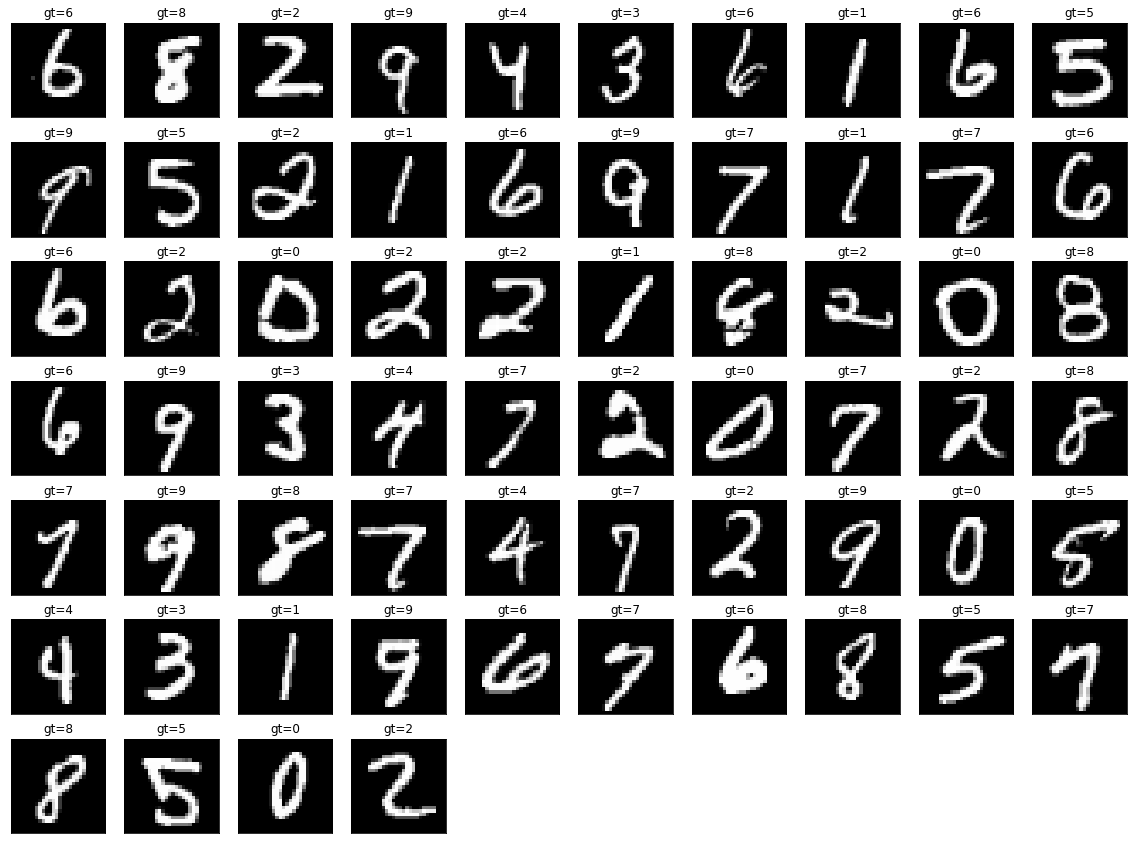

In [9]:
for X_batch, y_batch in train_dataset:
    visualize_batch(X_batch.numpy(), y_batch.numpy())
    break

## 3. Create MLP model
Network structure (2 hidden layers):  
FC(256) - FC(512) - FC(10)

### Layer Class
You can extend tf.keras.layers.Layers to define your own layers.  

Typical Methods:  
- `build(input_shape)` 
    - The build method is called when the input data is first supplied and dynamically builds the graph. So any initialization that is dependent on the input geometry (such as weight initialization) is best defined in the build method.
- `call(input, **kwargs)`
    - Layer's logic will be executed in this method
- `add_weight()`
    - Adds a new variable to the layer

More deteils:  
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer

In [10]:
class CustomDense(tf.keras.layers.Layer):
    """y = w.x+b"""
    def __init__(self, units, activation=None):
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = activation
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='he_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units),
                                 initializer='zeros',
                                 trainable=True)
    def call(self, inputs):
        if self.activation:
            return self.activation(tf.matmul(inputs, self.w) + self.b)
        else:
            return tf.matmul(inputs, self.w) + self.b

class CustomDropout(tf.keras.layers.Layer):
    def __init__(self, rate):
        super(CustomDropout, self).__init__()
        self.rate = rate
    
    def call(self, inputs, is_training=None):
        if is_training:
            return tf.nn.dropout(inputs, rate=self.rate)
        else:
            return inputs

In [11]:
class MLPWithDropout(tf.keras.Model):
    def __init__(self, units1, units2, units3, rate=0.5):
        super(MLPWithDropout, self).__init__(name="MLPWithDropout")
        self.dense1 = CustomDense(units1, activation=tf.nn.relu)
        self.dropout1 = CustomDropout(rate)
        self.dense2 = CustomDense(units2, activation=tf.nn.relu)
        self.dropout2 = CustomDropout(rate)
        self.dense3 = CustomDense(units3)
    
    def call(self, inputs, training=None):
        x = self.dense1(inputs)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        x = self.dense3(x)
        return x

## 4. Training

In [13]:
lr = 0.0001

n_dense1 = 256
n_dense2 = 512
n_dense3 = n_classes

epochs = 15
checkpoint_path = './checkpoints_3/model_{epoch:04d}.ckpt'

# ------------------------------------------------------------

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(lr)

# Define model
model = MLPWithDropout(n_dense1, n_dense2, n_dense3)

@tf.function
def train_on_batch(model, X, y, accuracy_i):
    # Open a GradientTape
    with tf.GradientTape() as tape:
        logits = model(X, training=True)
        loss_value = loss(y, logits)

    # Coumpute gradients
    gradients = tape.gradient(loss_value, model.trainable_weights)

    # Apply back propagation
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    # Update the runnning accuracy
    accuracy_i.update_state(y, logits)
    return loss_value

@tf.function
def eval_on_batch(model, X, y, accuracy_i):
    logits = model(X, training=False)
    loss_value = loss(y, logits)
    accuracy_i.update_state(y, logits)
    return loss_value
    
    
for epoch in range(epochs):
    
    # Training
    train_losses = []
    accuracy.reset_states()
    
    for step, (X, y) in enumerate(train_dataset):
        train_loss = train_on_batch(model, X, y, accuracy)
        train_losses.append(train_loss)
    
    train_accuracy = accuracy.result()
    train_loss = np.average(train_losses)
    
    # Validation
    accuracy.reset_states()
    validation_losses = []
    
    for X, y in validation_dataset:
        val_loss = eval_on_batch(model, X, y, accuracy)
        validation_losses.append(val_loss)

    validation_accuracy = accuracy.result()
    validation_loss = np.average(validation_losses)
    
    print('Epoch: {}, loss: {:.5f}, accuracy: {:.5f}, val_loss: {:.5f}, val_accuracy: {:.5f}'.format(
        epoch, train_loss, train_accuracy, validation_loss, validation_accuracy
    ))

Epoch: 0, loss: 0.13259, accuracy: 0.81138, val_loss: 0.06118, val_accuracy: 0.91408
Epoch: 1, loss: 0.05041, accuracy: 0.92862, val_loss: 0.04356, val_accuracy: 0.93733
Epoch: 2, loss: 0.03790, accuracy: 0.94623, val_loss: 0.03537, val_accuracy: 0.94817
Epoch: 3, loss: 0.03079, accuracy: 0.95696, val_loss: 0.03028, val_accuracy: 0.95675
Epoch: 4, loss: 0.02592, accuracy: 0.96377, val_loss: 0.02676, val_accuracy: 0.96225
Epoch: 5, loss: 0.02229, accuracy: 0.96952, val_loss: 0.02423, val_accuracy: 0.96583
Epoch: 6, loss: 0.01947, accuracy: 0.97396, val_loss: 0.02235, val_accuracy: 0.96867
Epoch: 7, loss: 0.01719, accuracy: 0.97733, val_loss: 0.02091, val_accuracy: 0.96958
Epoch: 8, loss: 0.01529, accuracy: 0.98052, val_loss: 0.01980, val_accuracy: 0.97158
Epoch: 9, loss: 0.01369, accuracy: 0.98296, val_loss: 0.01893, val_accuracy: 0.97292
Epoch: 10, loss: 0.01231, accuracy: 0.98479, val_loss: 0.01823, val_accuracy: 0.97367
Epoch: 11, loss: 0.01110, accuracy: 0.98669, val_loss: 0.01769, 

## 5. Test

In [14]:
accuracy.reset_states()
test_losses = []

for X, y in test_dataset:
    test_loss = eval_on_batch(model, X, y, accuracy)
    test_losses.append(test_loss)

test_accuracy = accuracy.result()
test_loss = np.average(test_losses)

print('loss: {:.5f}, accuracy: {:.5f}'.format(test_loss, test_accuracy))

loss: 0.01556, accuracy: 0.97660


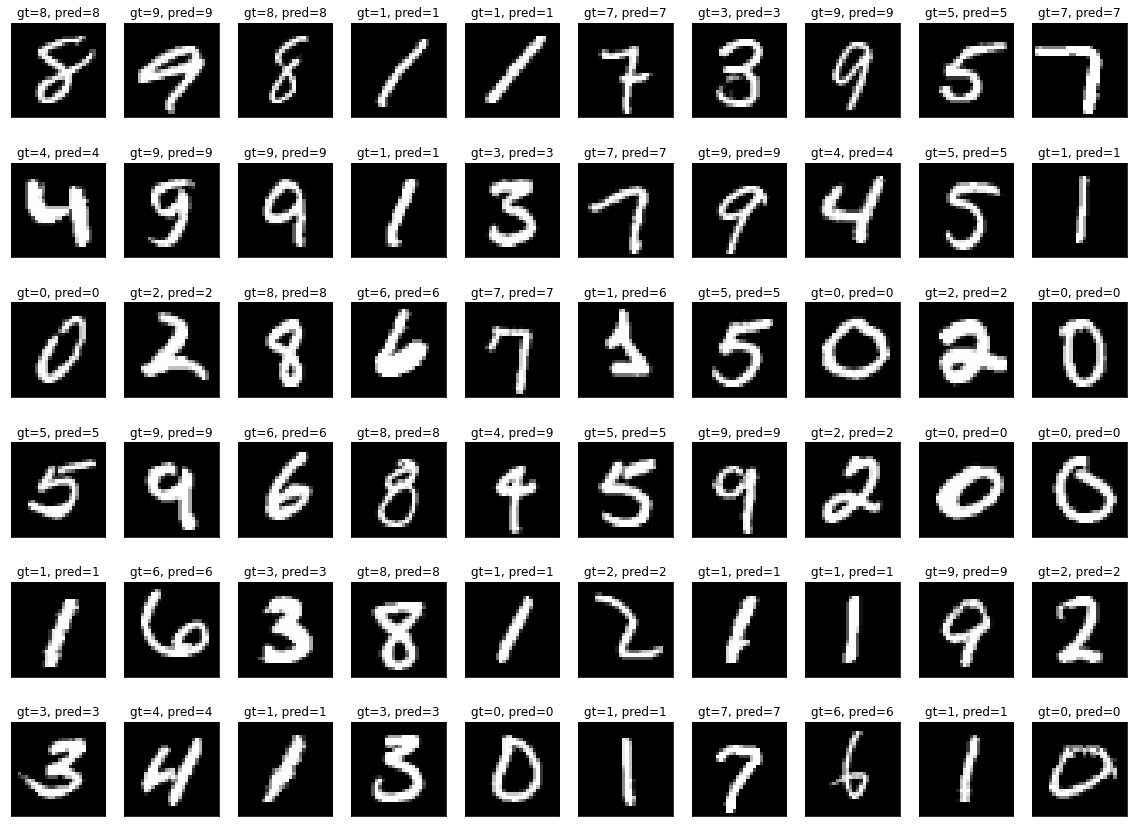

In [15]:
index = np.random.choice(np.arange(0, len(y_test)), size=60)
test_input = X_test[index]
y_true = tf.keras.utils.to_categorical(y_test[index], num_classes=n_classes)

predicted = model.predict(test_input)
predicted_label = np.argmax(predicted, axis=1)

visualize_batch(test_input, y_true, predicted_label)